In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/project.zip"


In [ ]:
path = "/content/drive/MyDrive/project"
BASE_PATH = "/content/drive/MyDrive/"

In [ ]:
# !unzip -q $zip_path -d $path

>

# 1 Import libraries

In [ ]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Plot and display architecture for InceptionV3 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
All done


## Split data into train, valid, test

In [ ]:
#train, valid  and test dataframes
train = pd.read_csv(f"{BASE_PATH}train.csv")
valid = pd.read_csv(f"{BASE_PATH}valid.csv")
test = pd.read_csv(f"{BASE_PATH}test.csv")

train["Paths"] = train["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
test["Paths"] = test["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
valid["Paths"] = valid["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
train.Labels.value_counts()

normal             6373
diabetes           6326
cataract           6242
others             6128
glaucoma           6030
myopia             5967
ageDegeneration    5755
hypertension       5487
Name: Labels, dtype: int64

## C- Data Augmentation

In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 48308 validated image filenames belonging to 8 classes.
Found 6038 validated image filenames belonging to 8 classes.
Found 6039 validated image filenames belonging to 8 classes.


## D- Represent a sample

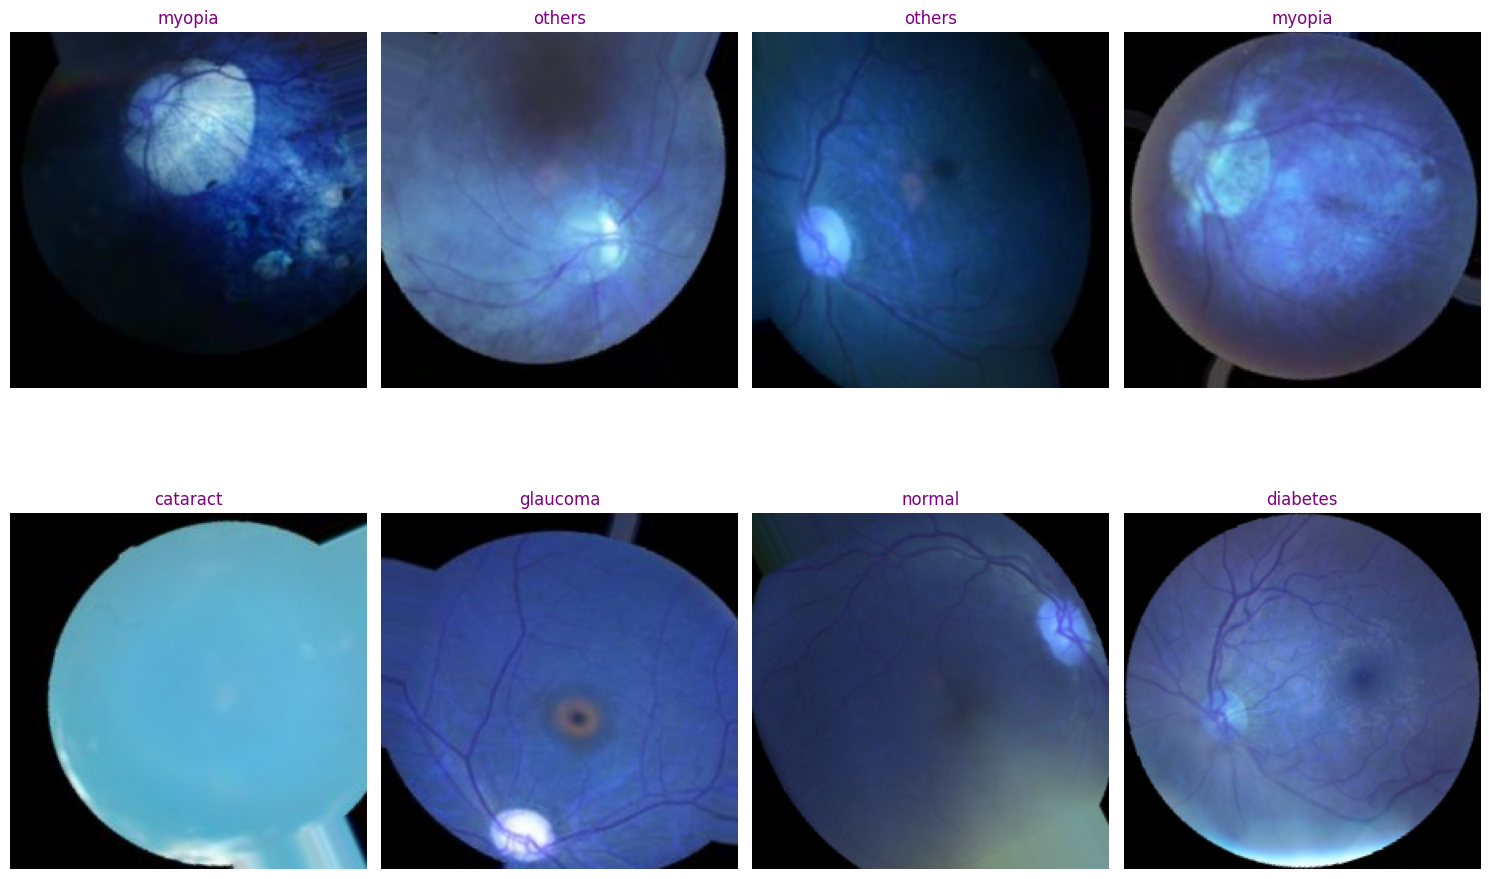

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

In [ ]:
# Define number of classes
num_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
np.random.seed(42)
# Define base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
ResNet50_model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
ResNet50_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
ResNet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Visualise the model

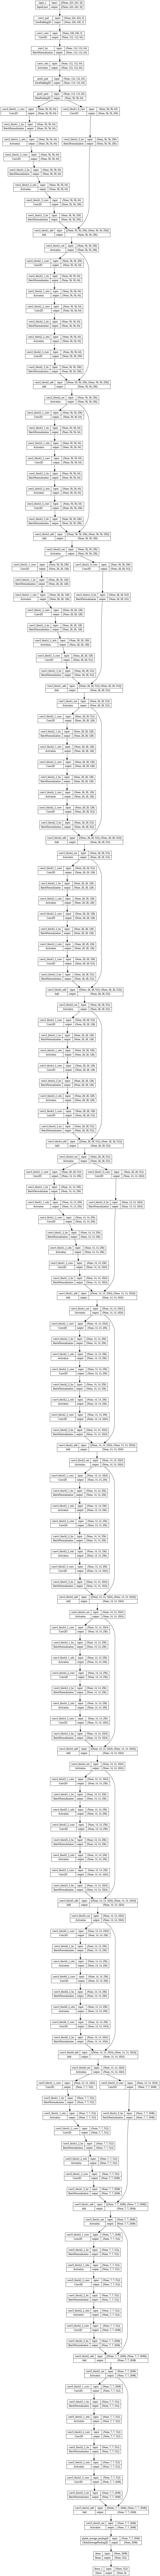

In [ ]:
# Plot and display architecture for ResNet50 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(ResNet50_model, to_file='ResNet50_model.png', show_shapes=True, show_layer_names=True)
Image(filename='ResNet50_model.png')

## Training the model

In [ ]:
np.random.seed(42)
# Train the model
history_ResNet50 = ResNet50_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
test_loss_resnet50, test_accuracy_resnet50 = ResNet50_model.evaluate(Test)

Epoch 1/15
2415/2415 [==============================] - 24757s 10s/step - loss: 1.3015 - accuracy: 0.5053 - val_loss: 1.2472 - val_accuracy: 0.5505
Epoch 2/15
2415/2415 [==============================] - 597s 247ms/step - loss: 1.0540 - accuracy: 0.5951 - val_loss: 1.2806 - val_accuracy: 0.5311
Epoch 3/15
2415/2415 [==============================] - 593s 245ms/step - loss: 0.9263 - accuracy: 0.6431 - val_loss: 1.1648 - val_accuracy: 0.5771
Epoch 4/15
2415/2415 [==============================] - 592s 245ms/step - loss: 0.8077 - accuracy: 0.6896 - val_loss: 0.8696 - val_accuracy: 0.6784
Epoch 5/15
2415/2415 [==============================] - 592s 245ms/step - loss: 0.6946 - accuracy: 0.7308 - val_loss: 0.7684 - val_accuracy: 0.7038
Epoch 6/15
2415/2415 [==============================] - 608s 252ms/step - loss: 0.5910 - accuracy: 0.7685 - val_loss: 0.7496 - val_accuracy: 0.7229
Epoch 7/15
2415/2415 [==============================] - 601s 249ms/step - loss: 0.5038 - accuracy: 0.7993 - val_

In [ ]:
tr_acc_ResNet50 = history_ResNet50.history['accuracy']
tr_loss_ResNet50 = history_ResNet50.history['loss']
v_acc_ResNet50 = history_ResNet50.history['val_accuracy']
v_loss_ResNet50 = history_ResNet50.history['val_loss']
index_acc_ResNet50 = np.argmax(v_acc_ResNet50)
high_Vacc_ResNet50 = v_acc_ResNet50[index_acc_ResNet50]
index_loss_ResNet50 = np.argmin(v_loss_ResNet50)
low_Vloss_ResNet50 = v_loss_ResNet50[index_loss_ResNet50]
Epochs_ResNet50 = list(range(1, len(tr_acc_ResNet50) + 1))
best_acc_ResNet50 = f'Best epoch ={str(index_acc_ResNet50 + 1)}'
best_loss_ResNet50 = f'Best epoch ={str(index_loss_ResNet50 + 1)}'

In [ ]:


# save the model
ResNet50_model.save(f"{BASE_PATH}ResNet50_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}ResNet50_model_history.npy", history_ResNet50.history)

import pickle

with open(f"{BASE_PATH}history_ResNet50.pickle", 'wb') as handle:
    pickle.dump(history_ResNet50.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 6. EfficientNetB0

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model



def create_model():
    pretrained_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    pretrained_model.trainable = True

    # Add custom head
    x = GlobalAveragePooling2D()(pretrained_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create model
    EfficientNetB0_model = Model(inputs=pretrained_model.input, outputs=predictions)

    # Compile model
    EfficientNetB0_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return EfficientNetB0_model




EfficientNetB0_model = create_model()



In [ ]:
EfficientNetB0_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

## Visualise the model

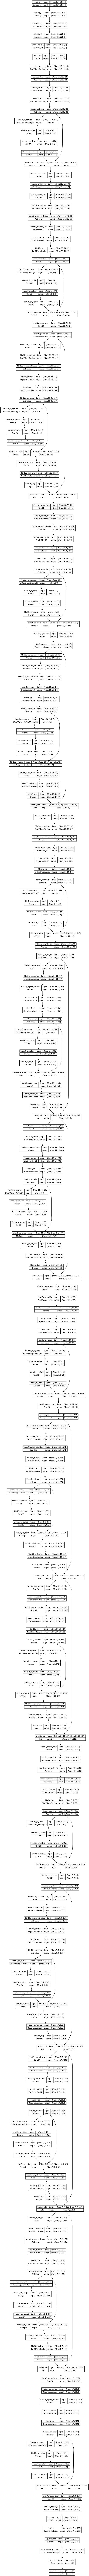

In [ ]:
# Plot and display architecture for EfficientNetB0 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(EfficientNetB0_model, to_file='EfficientNetB0_model.png', show_shapes=True, show_layer_names=True)
Image(filename='EfficientNetB0_model.png')

## Training the model

In [ ]:
# Train the model
np.random.seed(42)
history_EfficientNetB0 = EfficientNetB0_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
test_loss_efficientnetb0, test_accuracy_efficientnetb0 = EfficientNetB0_model.evaluate(Test)

Epoch 1/15
2415/2415 [==============================] - 13526s 6s/step - loss: 0.9774 - accuracy: 0.6334 - val_loss: 1.0539 - val_accuracy: 0.6375
Epoch 2/15
2415/2415 [==============================] - 974s 403ms/step - loss: 0.6580 - accuracy: 0.7519 - val_loss: 0.6022 - val_accuracy: 0.7846
Epoch 3/15
2415/2415 [==============================] - 980s 406ms/step - loss: 0.5064 - accuracy: 0.8076 - val_loss: 0.5045 - val_accuracy: 0.8037
Epoch 4/15
2415/2415 [==============================] - 979s 405ms/step - loss: 0.4146 - accuracy: 0.8417 - val_loss: 0.4175 - val_accuracy: 0.8365
Epoch 5/15
2415/2415 [==============================] - 964s 399ms/step - loss: 0.3559 - accuracy: 0.8645 - val_loss: 0.3883 - val_accuracy: 0.8467
Epoch 6/15
2415/2415 [==============================] - 974s 403ms/step - loss: 0.3126 - accuracy: 0.8809 - val_loss: 0.4089 - val_accuracy: 0.8497
Epoch 7/15
2415/2415 [==============================] - 972s 402ms/step - loss: 0.2734 - accuracy: 0.8961 - val_l

In [ ]:
tr_acc_EfficientNetB0 = history_EfficientNetB0.history['accuracy']
tr_loss_EfficientNetB0 = history_EfficientNetB0.history['loss']
v_acc_EfficientNetB0 = history_EfficientNetB0.history['val_accuracy']
v_loss_EfficientNetB0 = history_EfficientNetB0.history['val_loss']
index_acc_EfficientNetB0 = np.argmax(v_acc_EfficientNetB0)
high_Vacc_EfficientNetB0 = v_acc_EfficientNetB0[index_acc_EfficientNetB0]
index_loss_EfficientNetB0 = np.argmin(v_loss_EfficientNetB0)
low_Vloss_EfficientNetB0 = v_loss_EfficientNetB0[index_loss_EfficientNetB0]
Epochs_EfficientNetB0 = list(range(1, len(tr_acc_EfficientNetB0) + 1))
best_acc_EfficientNetB0 = f'Best epoch ={str(index_acc_EfficientNetB0 + 1)}'
best_loss_EfficientNetB0 = f'Best epoch ={str(index_loss_EfficientNetB0 + 1)}'

In [ ]:
# save the model
EfficientNetB0_model.save(f"EfficientNetB0_model.h5")
# save the history of the model
np.save(f"EfficientNetB0_model_history.npy", history_EfficientNetB0.history)

import pickle

with open(f"{BASE_PATH}history_EfficientNetB0.pickle", 'wb') as handle:
    pickle.dump(history_EfficientNetB0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
